In [24]:
import random as rd
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
class TrafficSimulator:
    
    def __init__(self, road_len, p_car, v_max, p_slow, verbose = True, ):
        """
        Initialize traffic simulation:
        road_lend: length of the road (circumference)
        p_car: car density
        v_max: maximum speed
        p_slow: probability of slowing down 1 speed unit
        verbose: whether we want to display the states
        """      
        self.road_len = road_len
        self.v_max = v_max
        self.p_slow = p_slow
        self.verbose = verbose        
        self.state= sc.zeros([road_len], int)
        
        for i in range(road_len):
            if rd.random() < p_car:
                # All cars start at full speed
                self.state[i] = self.v_max                
            else:
                self.state[i] = -1
        
    def display(self):
        """
        Method for visualizing the state of the model
        """     
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        
    def update(self):
        """
        Advances the simulation 1 timestep forward by doing the following on all cars:
         - Increase speed +1 if v smaller than v_max and distance to next vehicle > v+1
         - if distance to next car < v, slow down to d-1.
         - If speed > 0, randomly decrease speed by 1.
         - Display
         - Advance all cars v steps.
        """      
        flow = 0     
        
        for i, v in enumerate(self.state):
            if v >= 0:
                #get distance to next car
                d = 1
                while self.state[(i + d) % self.road_len] == -1:
                    d += 1
                #update speeds
                if d > v + 1:
                    self.state[i] = min(self.state[i] + 1, self.v_max)
                else:
                    self.state[i] = d - 1
                if self.state[i] > 0 and rd.random() < self.p_slow:
                    self.state[i] -= 1
                #Count flow
                if i + v > self.road_len: flow += 1
                        
        #We display before moving the cars
        if self.verbose: self.display()    
                
        copy_state = self.state[:]
        i = 0
        while i < len(copy_state):
            v = copy_state[i]
            if v >= 0:
                self.state[i] = -1
                i += v
                self.state[i % self.road_len] = v
                i += 1
            else: 
                i+=1 
        return flow
    
    def run(self, n_steps = 100):
        flow_sum = 0.0
        for step in range(n_steps):
            flow_sum += self.update()
        return flow_sum / n_steps

In [22]:
a = TrafficSimulator(100, .4, 5, .5)
a.run()

0.03....01..5......2..000.0000.00003...2..4........00002..01.2..1.1..01..1.1.0.1..005.....00001..1.0
1.1...1.0.2......3...0000.0001.0000...2..3....4....0001..01.1..0.0.1.1.2..1.01..1.00.....00001.1..00
.1.1...01...2.......00001.001.00001.....3...3.....0001.0.0.0.1.1.1..1.2..1.01.2..000.....0001.1.1.00
..0.1..1.2....3.....0000.000.00001.2.......2...2..001.01.0.1..1.0.2..1..0.00.2..0000.....000.0.1.000
..1..2..2..2.....2..0001.000.0001.2..2.......3...000.00.01..1..00...1.1.1.00...00000.....000.0..0000
...2...2..1..3.....0000.0000.000.1..1..2........0001.00.1.2..0.01....0.0.000...00001.....001.0..0000
.....3...0.1....2..0001.0000.000..2..1...3......001.001..2..01.1.2...1.0.001...0001.1....01.01..0000
........00..2.....0000.00000.000....1.2.....3...00.000.2...00.1.2..1..00.01.2..000.1.1...0.01.1.0000
........01....2...0001.00000.000.....2..3......000.000...1.00..1..0.1.00.1.2..0001..1.1..0.0.0.00000
........0.1.....1.001.000000.001.......2...3...000.001....000...0.0..000..2..0000.2..0.1.0.

0.1

In [23]:
b = TrafficSimulator(100, .1, 5, .5)
b.run()

.5.....4....04.......1.4....................................................................4.......
......4....01....4....1....5....................................................................4...
4.........00.1.......1.1........4...................................................................
....5.....01..1.......1.2...........5...............................................................
.........00.2..1.......1..3..............5..........................................................
.........01...1.2.......1....3................5.....................................................
.........0.2...1..2......1......3..................4................................................
.........0...1..1...2.....2........4...................5............................................
.........0....1..2....2.....2..........5....................5.......................................
.........1.....1...2....2.....2.............4....................5.........................

0.19

## Traffic Flow Plot

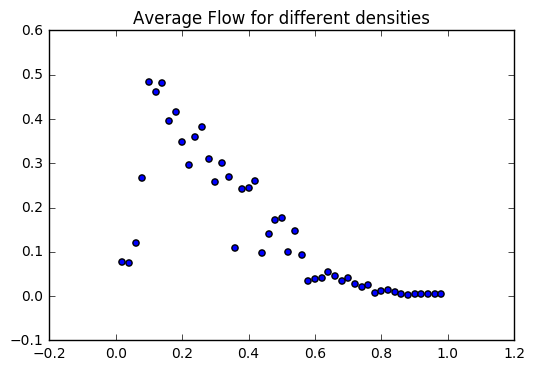

In [26]:
densities = sc.arange(0.02,1,.02)
flow = [TrafficSimulator(100, d, 5, .2, verbose = False).run(n_steps = 1000) for d in densities]
plt.scatter(densities, flow)
plt.title("Average Flow for different densities")
plt.show()

## "Always in the middle" traffic rule

In [33]:
class MiddleTrafficSimulator(TrafficSimulator):
    """
    This class will take a normal traffic simulator, but will update it with the 
    always in the middle rule (every car tries to have the same distance between the next
    car and the previous one)
    """
    
    def update(self):
        """
        - Check distances front and back
        - If there is more distance front than back, v+1
        - If there is more distance back than front, v-1
        - Random deceleration 
        - Display
        - Move cars
        """
        flow = 0             
        for i, v in enumerate(self.state):
            if v >= 0:
                
                d_front = 1
                d_back = 1
                while self.state[(i + d_front) % self.road_len] == -1:
                    d_front += 1
                while self.state[(i - d_back) % self.road_len] == -1:
                    d_back += 1
                              
                #update speeds (bias towards accelerating)
                if d_front + 1 > d_back:
                    self.state[i] = min(self.state[i] + 1, self.v_max)
                else:
                    self.state[i] = min( max(v - 1, 0), d_front - 1)
                if self.state[i] > 0 and rd.random() < self.p_slow:
                    self.state[i] -= 1
                #Count flow
                if i + v > self.road_len: flow += 1
                        
        #We display before moving the cars
        if self.verbose: self.display()    
                
        copy_state = self.state[:]
        i = 0
        while i < len(copy_state):
            v = copy_state[i]
            if v >= 0:
                self.state[i] = -1
                i += v
                self.state[i % self.road_len] = v
                i += 1
            else: 
                i+=1 
        return flow

In [41]:
MiddleTrafficSimulator(100, .8, 5, .5, verbose = True).run()

0444.0444.04455455.4.05555...1.044.045444444555455545544.4..1.4.0444.045.0555455445.05..054555545.4.
0.05.4.05.4.0555.4.4.5.055.4..00.5.05.05554.0555.05555.4.04..2..044..054.0.04455.05.4...054.05545...
0.1..1.05...055..0.05..0455...04...05.4.054.4.04.04.05.041...04.1.5..0.5.1.4.04450..5..01.5.045.4..0
4..1..00....05...0.5...054....05...0..0.05..0.5..0551..0514..0..0.5..1...0.040.0505....014..0455...0
...04.01....1....05....05....00....05.1.1...0.5..0.02..1.04..4..0....0.4.1.1.1.050.....1.2..0.05.5.0
5..0..025....0...1.....4.....00....0..0.04..1....0.5..1.00...05.1....0...0.4..00.0...1..2..00.1..0.0
...0.01.02...1....1........1.00....0..0.0...04...1....0.00...0..2..1.1...0....04.1....0...011..0.0.0
...0.0.01..3..1....1........001....0..0.1...0....4....0.00...0....1.1.2..0....0..0.4..0...0.2..0.1.0
...0.1.0.1....4.....1.......01.2...0..0..2..1........00.01...1.....0.1..00....0..1....04..0...01..00
...0..00..2.......2..1......0.1..1.1..1....1.2.......00.1.1...2....0..0.01....0...2...1...0

0.1

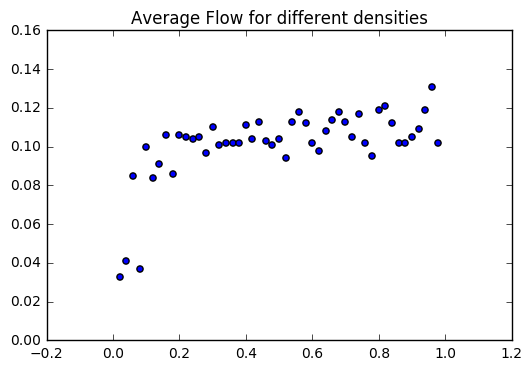

In [39]:
densities = sc.arange(0.02,1,.02)
flow = [MiddleTrafficSimulator(100, d, 5, .2, verbose = False).run(n_steps = 1000) for d in densities]
plt.scatter(densities, flow)
plt.title("Average Flow for different densities")
plt.show()